In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import scipy.interpolate
import os

Defining EOS objects


In [ ]:
class EOS():

    def __init__(self):
        print("Setting up base class EOS")

    def P(self, e, rho):
        pass

class GammaLaw(EOS):

    def __init__(self, K, Gamma):
        # EOS.__init__(self)
        print("Setting up Gamma-law EOS with K =", K, "and Gamma =", Gamma)
        self.K = K
        self.Gamma = Gamma

    def P(self, e, rho):
        return (self.Gamma - 1.0)*e*rho

    def P_cold(self, rho):
      return (self.K * rho ** self.Gamma)

    def e_cold(self, rho):
      return self.P_cold(rho) / ((self.Gamma - 1)*rho)

    def rho(self, P):
      return (P / self.K) ** (1 / self.Gamma)

    def soundspeed(self, rho):
      # soundspeed = sqrt(dP / d rho)
      return (self.Gamma * self.K * rho **(self.Gamma - 1)) ** (1/2)

    def name(self):
      print('Gamma Law')

class Dust(EOS):

    def __init__(self):
        EOS.__init__(self)
        print("Setting up Dust EOS")

    def P(self, e, rho):
        return 0.0

    def P_cold(self, rho):
      return 0.0

    def e_cold(self, rho):
      return 0.0

    def rho(self, P):
      pass

    def soundspeed(self, rho):
      #since P = 0 for dust
      return 0.0

    def name(self):
      print('Dust')

class Piecewise(EOS):

    def __init__(self, K, Gamma_1, Gamma_0):
        print("Setting up Gamma-law EOS with K =", K, "Gamma_1 =", Gamma_1, "Gamma_0 = ", Gamma_0)
        self.K = K
        self.Gamma = Gamma_1
        # assuming given rho_nucl = 1.4 * 10^-4 solar mass / cubic km
        self.rho_nucl = 1.4e-4
        # inside rho_nucl
        self.Gamma_0 = Gamma_0
        # assuming K_0 is given in problem 10.2
        self.K_0 = 6.147e4
        self.K_1 = 0
        self.b_1 = 0
        self.compute_constants()

    def reset_gamma0(self, gamma0):
      print('Resetting Gamma_0 to', gamma0)
      self.Gamma_0 = gamma0
      self.compute_constants()

    def compute_constants(self):
      self.K_1 = self.K_0 * (self.rho_nucl ** (self.Gamma_0 - self.Gamma))
      self.b_1 = (self.K_0 * self.rho_nucl ** (self.Gamma_0 - 1)) * ((self.Gamma_0 - 1)**(-1) - (self.Gamma - 1)**(-1))

    def P(self, e, rho):
      e_thermal = e - self.e_cold(rho)
      P_thermal = (1 / 3) * e_thermal * rho
      P_cold = self.P_cold(rho)
      return P_cold + P_thermal

    def P_cold(self, rho):
      # self.compute_constants()
      # check whether or not density is within nuclear density domain
      if rho <= self.rho_nucl:
        return self.K_0 * rho ** (self.Gamma_0)
      else:
        return (self.K_1 * rho ** self.Gamma)

    def e_cold(self, rho):
      # self.compute_constants()

      if rho <= self.rho_nucl:
        return self.K_0 * (1 / (self.Gamma_0 - 1)) * (rho**(self.Gamma_0 - 1))
      else:
        return self.b_1 + self.K_1 * (1 / (self.Gamma - 1)) * (rho**(self.Gamma - 1))

    def rho(self, P):
      P_nucl = self.P_cold(self.rho_nucl)

      if P >= P_nucl:
        return (P / self.K) ** (1 / self.Gamma)
      else:
        return (P / self.K_0) ** (1 / self.Gamma_0)

    def soundspeed(self, rho):
      if rho <= self.rho_nucl:
        return (self.Gamma_0 * self.K_0 * rho **(self.Gamma_0 - 1)) ** (1/2)
      else:
        return (self.Gamma * self.K * rho **(self.Gamma - 1)) ** (1/2)

    def name(self):
      print('Piecewise Gamma Law')

# Creating Initial Data class.

Produces initial data that's either constant density (for dust) or equilibrium star.

Returns uniform grids of r and m.

In [ ]:
def zero_crossing(r, x):
    return x[0] # check for when our pressure is zero, so we know when to stop integrating

zero_crossing.terminal = True

class InitialData():
  def __init__(self):
    print('Creating initial data')

class constantDensityStar(InitialData):
  def __init__(self, R, M, n):
    self.R = R
    self.M = M
    self.n = n

  def initialize_data(self):
    delta_m = self.M / self.n
    rho = self.M / ((4/3) * np.pi * self.R ** 3)

    m_grid = np.zeros(self.n)
    r_grid = np.zeros(self.n)

    for i in range(1, self.n):
      current_m = i * delta_m
      m_grid[i] = current_m
      r_grid[i] = (m[i] / ((4/3)*np.pi*rho))**(1/3)
  def name(self):
    return 'Constant Density Star'

    return m_grid, r_grid


class equilibriumStar(InitialData):
  def __init__(self, EOS, rho_c, n):
    self.EOS = EOS
    self.rho_c = rho_c
    self.n = n

# -----------------------
  def equilibrium(self, r, x):
    # this function calculates and returns the derivatives at each point

    # assign each variable to a vector element
    P = x[0]
    m = x[1]

    # newton's constant in terms of km, solar mass, millisecond
    G = 1.327e5
    # G = 1

    # define each ode
    rho = self.EOS.rho(P)
    dmdr = 4*(np.pi)*(r**2)*rho
    # print(r)
    if r == 0:
      dPdr = 0
    else:
      dPdr = (-rho)*G*m / (r**2)

    return [dPdr, dmdr]

  def name(self):
    return 'Equilibrium Star'

  def integrator(self, r_final):
    # setting vector of initial values (initial pressure, initial mass) to be solved by solve_ivp:
    P_central = self.EOS.P_cold(self.rho_c)
    m_init = 0
    x0 = [P_central, m_init]

    # want to stop integrating when P = 0, so use zero crossing event
    r = np.linspace(0, r_final, 10000)
    tol = 1.e-8
    sol = solve_ivp(self.equilibrium, [0, r_final], x0, t_eval=r, atol=tol, rtol=tol, events = zero_crossing)
    # return zero-th row of solution, which contains values of x
    return sol.t, sol.y[0], sol.y[1]

  def interpolate(self):

    #create a star
    rfinal = 1100 #sets upper bound on what we integrate to --> played around with this number and found it stops integrating a little before r=1100
    radii, pressure, masses = self.integrator(rfinal)

    # set our total M and R to our largest value in each array
    M = max(masses)
    R = max(radii)

    #interpolating from our different points after integrating
    r_of_m = scipy.interpolate.interp1d(masses, radii, 'cubic')

    # update our r_grid and m_grid
    delta_m = M / self.n
    print('delta_m = ', delta_m)

    m_grid = np.linspace(delta_m, M, num = self.n)
    r_grid = np.zeros(self.n)
    for i in range(0, self.n):
      r_grid[i] = r_of_m(m_grid[i])

    return m_grid, r_grid
# ----------------------------------------------------------------------------------
  def initialize_data(self):
    R = 1.9
    K = self.EOS.K
    Gamma = self.EOS.Gamma

    m, r = self.interpolate()
    return m, r

Defining gridfunction (cell-centered & vertex-centered) objects

In [ ]:
class GridFunction:

  def __init__(self, x, name):
    #passing some array x into our gridfunction
    self.x = x
    self.name = name

    # print("Creating GridFunction Object named", self.name)

    self.delta = x[1] - x[0] # distance between gridpoints
    self.n = np.size(x)
    self.data = np.zeros(self.n)
    self.deriv = np.zeros(self.n)

  def __getitem__(self, index):
    return self.data[index]

  def __setitem__(self, index, value):
    self.data[index] = value

  def equals_const(self, value):
    for i in range(self.n):
      self.data[i] = value

  def equals(self, gf):
    # make gridfunction object contain same data as another
    for i in range(self.n):
      self.data[i] = gf.data[i]

  def plus(self, factor, gf):
    # add data of other gridfuction times a given factor
    for i in range(self.n):
      self.data[i] += factor * gf.data[i]

  def plot(self):
    #plots data over x (which is our values of m)
    plt.plot(self.x, self.data)
    plt.xlabel("m", size = 14)
    plt.ylabel(self.name, size = 14)
    plt.show()


In [ ]:
# Creating child classes for vertex and cell centered grid functions:
class VertexCentered(GridFunction):
  def dm(self):
    # filling out our derivative grid with values
    for i in range(1, self.n):
      self.deriv[i] = (self.data[i] - self.data[i - 1]) / self.delta

    # boundary condition - will be cell centered after taking derivative
    self.deriv[0] = self.data[0] / self.delta
    return self.deriv

In [ ]:
class CellCentered(GridFunction):
  def dm(self):
    for i in range(0, self.n - 1):
      self.deriv[i] = (self.data[i+1] - self.data[i]) / self.delta

    # boundary condition
    self.deriv[self.n - 1] = -2*(self.data[self.n - 1]) / self.delta
    return self.deriv

In [ ]:
# links together all of our gridfunctions
class State:

  def __init__(self, x, name):
    self.x = x
    self.name = name
    # print("Creating State object named", self.name)

    # our depnedent variables
    self.u = VertexCentered(x, "u")
    self.r = VertexCentered(x, "r")
    self.rho = CellCentered(x, "rho")
    self.e = CellCentered(x, "e")

  def equals(self, state):
    self.u.equals(state.u)
    self.r.equals(state.r)
    self.rho.equals(state.rho)
    self.e.equals(state.e)

  def plus(self, factor, state):
    self.u.plus(factor, state.u)
    self.r.plus(factor, state.r)
    self.rho.plus(factor, state.rho)
    self.e.plus(factor, state.e)

  def plot(self):
    self.u.plot()
    self.r.plot()
    self.rho.plot()
    self.e.plot()

Defining integrator object - this will evolve the star



In [ ]:
class Integrator:

  def __init__(self, x, n_m, Star):
    self.old = State(x, "old")
    self.k1 = State(x, "k1")
    self.k2 = State(x, "k2")
    self.k3 = State(x, "k3")
    self.k4 = State(x, "k4")
    self.inter = State(x, "intermediate")
    self.delta_x = x[1] - x[0]
    self.n = np.size(x)
    self.x = x
    self.InitialStar = Star
    self.EOS = Star.EOS
    # auxillary variables
    self.r2u = VertexCentered(x, 'r^2  u')
    self.r3 = VertexCentered(x, 'r^3')
    self.P = CellCentered(x, 'P')

    # create a monitor file that will keep track of varibles at the same mass shell m at different points in time
    self.n_m = n_m
    self.monitor_handle = open("./monitor_" + str(self.n_m) + ".txt", "w")
    self.monitor_handle.write('# m --- t --- r --- u --- rho --- e\n')

  def __del__(self):
    self.monitor_handle.close()


  def dr3_dm(self, r):
    for i in range(self.n):
      self.r3[i] = r[i] ** 3
    return self.r3.dm()

  # initialize the rest of our data. Pass in the star (Initial-Data-Class type)
  def init_data(self):
    #density sphere M=1 , R=5
    r = VertexCentered(self.x, 'r')
    drdm = r.dm()

    if self.InitialStar.name() == 'Equilibrium Star':
      mass, radius = self.InitialStar.initialize_data()

      #update the auxillary r^3 so then we can calculate its derivatives and then the density at each point
      for i in range(self.n):
        self.r3[i] = radius[i] ** 3

      dr3dm = self.r3.dm()

      for i in range(self.n):

        self.old.rho[i] = 3 / (4* np.pi* dr3dm[i]) # set density using our auxilary (r^3) variable
        self.old.r[i] = radius[i] # set gridfunction r equal to our inital data that we generated
        self.old.u[i] = 0 # equilibrium star ==> initial velocity is 0
        self.old.e[i] = self.EOS.e_cold(self.old.rho[i])

    if self.InitialStar.name() == 'Constant Density Star':
      mass, radius = self.InitialStar.initialize_data()
      for i in range(self.n):

        self.old.e[i] = 0 # set to zero for dust
        self.old.rho[i] = self.EOS.M / ((4 / 3) * np.pi * self.EOS.R**3) # need to set density first to be able to calculate r
        self.old.r[i] = (self.x[i] /((4 / 3) * np.pi * self.old.rho[i])) ** (1/3)
        self.old.u[i] = 0 # equilibrium star ==> initial velocity is 0
    return [self.old.rho, self.old.r, self.old.u, self.P, self.old.e]

# will call this method at various times t where we create a file, copy the data for r, u, rho, e , and then close the file
  def snapshot(self, t):
    file_name = 'data_at_time_' + str(t) + '.txt'
    file_handle = open(file_name, 'w') # need w because we're writing to the file
    file_handle.write('# snapshot at time:' + str(t) + '\n')
    file_handle.write('# m --- r --- u --- rho --- e\n')
    # loop through and record each gridpoint for each variable
    for i in range(self.n):
      data = " {0} {1} {2} {3} {4}\n".format(self.x[i], self.old.r.data[i], self.old.u.data[i], self.old.rho.data[i], self.old.e.data[i])
      file_handle.write(data)
    file_handle.close()

  # monitor
  def monitor(self, t):
    delta = int(self.n / self.n_m) # n_m = number of masses we want to track, need to divide number of gridpoints by n_m to get the right increment for the # of shells
    for i in range(0, self.n, delta):
      data = " {0} {1} {2} {3} {4} {5}\n".format(self.x[i], t, self.old.r.data[i], self.old.u.data[i], self.old.rho.data[i], self.old.e.data[i])
      self.monitor_handle.write(data)

  def calculate_delta_t(self, courant): # calculates a delta t at every point, then returns the minimum
    t_grid = np.zeros(self.n)
    for i in range(self.n):
      a = self.EOS.soundspeed(self.old.rho[i])
      if a == 0 or a <= 0:
        pass
      else:
        t_grid[i] = 1/(self.old.rho[i]*self.old.r[i]**2 * a)
        # t_grid[i] = courant * self.delta_x / (4 * np.pi * self.old.rho[i] * a)
    # print('tgrid', t_grid)
    # print('soundspeed:', a)
    return courant * self.delta_x * np.min(t_grid) / (4 * np.pi)

  def integrate(self, t_max, n_plot, n_t, plots):


    #==========================================================================================
    # these variables are only used to produce density vs time graph and velocity profiles.
    t_list = []
    rho_c_list = []

    utracker1 = np.zeros(self.n)
    mtracker1 = np.zeros(self.n)

    utracker2 = np.zeros(self.n)
    mtracker2 = np.zeros(self.n)

    ulist = []
    mlist = []
    #==========================================================================================
    courant = 1
    t = 0.0
    n_step = 0

    self.delta_t = self.min_delta_r()
    while (t < t_max):
      if self.InitialStar.name() == 'Equilibrium Star':
        self.delta_t = self.calculate_delta_t(courant)
        # self.delta_t = 0.01

      if self.InitialStar.name() == 'Constant Density Star':
        self.delta_t = self.min_delta_r()

      # if n_step % n_plot == 0:
      #   if plots == 0:
      #     pass
      #   else:
      #     #don't want a bunch of plots so not plotting at every time step
      #     print('t = ', t)
      #     self.old.r.plot()
      #     self.old.u.plot()
      #     self.old.rho.plot()
      #     self.old.e.plot()

      # also need to take snapshots at certain points in time, based what we choose n_t to be
      if n_step % n_t == 0:
        self.snapshot(t)
      self.monitor(t)
      # update our t list and rho_c list
      t_list.append(t)
      rho_c_list.append(self.old.rho[0])

      if 6 < t < 6.5:
        if utracker1[1] == 0:
          for i in range(self.n):
            utracker1[i] = self.old.u[i]
            mtracker1[i] = self.x[i]

      if 7 < t < 8:
        if utracker2[1] == 0:
          for i in range(self.n):
            utracker2[i] = self.old.u[i]
            mtracker2[i] = self.x[i]
      ulist = [utracker1, utracker2]
      mlist = [mtracker1, mtracker2]


      self.RK4()
      n_step += 1
      # print('densities', self.old.rho[0], self.old.rho[1], self.old.rho[2])
      t += self.delta_t
      # print('Integrated, t=', t)
      # print('Delta t=', self.delta_t)
    return t_list, rho_c_list, ulist, mlist

  def min_delta_r(self):
   # calculate the minimum difference between each r
    r_data = self.old.r.data
    min_val = abs(r_data[1] - r_data[0])

    for i in range(self.n - 1):
      # check the difference between each point, and if its lower, then will update the minimum value
      if abs(r_data[i + 1] - r_data[i]) < min_val:
        min_val = abs(r_data[i + 1] - r_data[i])

    return min_val

  def dr2udm(self, r, u):
    for i in range(self.n):
      # fill our r^2u grid
      self.r2u[i] = (r.data[i] ** 2) * u.data[i]
    return self.r2u.dm()

  def dp_dm(self, e, rho):
    for i in range(self.n):
      self.P[i] = self.EOS.P(e[i], rho[i])
    return self.P.dm()

  def compute_derivs(self, current, derivs):
    u = current.u
    r = current.r
    rho = current.rho
    e = current.e

    # Update the pressure when computing derivatives
    for i in range(self.n):
      self.P[i] = self.EOS.K * self.old.rho[i] ** (self.EOS.Gamma)

    d_r2u_dm = self.dr2udm(r, u)

    dpdm = self.dp_dm(e, rho)
    drdm = r.dm()
    dudm = u.dm()

    G = 1.327e5
    for i in range(self.n):
      derivs.u[i] = -4 * np.pi * (r[i]**2) * (dpdm[i]) - (G * self.x[i] / r[i]**2) # -Gm / r^2
      derivs.r[i] = u[i]
      derivs.rho[i] = -4 * np.pi * (rho[i]**2) * d_r2u_dm[i]
      derivs.e[i] = -4 * np.pi * self.EOS.P(e[i], rho[i]) * d_r2u_dm[i]
    # print('drdm', drdm[0])

  def RK4(self):
    #step 1
    self.compute_derivs(self.old, self.k1)
    #step 2
    self.inter.equals(self.old)
    self.inter.plus(self.delta_t / 2.0, self.k1)
    self.compute_derivs(self.inter, self.k2)
    #step 3
    self.inter.equals(self.old)
    self.inter.plus(self.delta_t / 2.0, self.k2)
    self.compute_derivs(self.inter, self.k3)
    #step 4
    self.inter.equals(self.old)
    self.inter.plus(self.delta_t, self.k3)
    self.compute_derivs(self.inter, self.k4)
    # final
    self.old.plus(self.delta_t / 6.0, self.k1)
    self.old.plus(self.delta_t / 3.0, self.k2)
    self.old.plus(self.delta_t / 3.0, self.k3)
    self.old.plus(self.delta_t / 6.0, self.k4)

Setting up Gamma-law EOS with K = 61470.0 Gamma_1 = 2.5 Gamma_0 =  1.3333333333333333
delta_m =  0.04487406690779199


<ipython-input-19-346b76f51bcb>:114: RuntimeWarning: invalid value encountered in double_scalars
  return (P / self.K_0) ** (1 / self.Gamma_0)


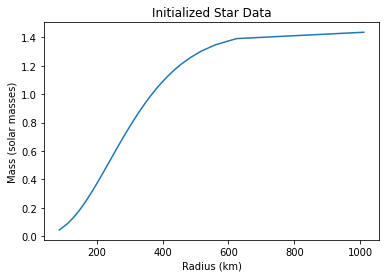

In [ ]:
K = 6.147e4
Gamma_0 = 4/3
Gamma_1 = 5/2
rho_c = 1.8e-8
n = 32

n_plot = 10
plots = 1
n_t = 100
n_m = 5

EOS = Piecewise(K, Gamma_1, Gamma_0)
InitialStar = equilibriumStar(EOS, rho_c, n)

m, r = InitialStar.initialize_data()


# Plot the data to see that it is the same as before.
plt.plot(r,m)
plt.xlabel('Radius (km)')
plt.ylabel('Mass (solar masses)')
plt.title('Initialized Star Data')
plt.show()

Resetting Gamma_0 to 1.4
delta_m =  0.006296937557310432


<ipython-input-19-346b76f51bcb>:114: RuntimeWarning: invalid value encountered in double_scalars
  return (P / self.K_0) ** (1 / self.Gamma_0)
<ipython-input-19-346b76f51bcb>:104: RuntimeWarning: invalid value encountered in double_scalars
  return self.K_0 * (1 / (self.Gamma_0 - 1)) * (rho**(self.Gamma_0 - 1))
<ipython-input-19-346b76f51bcb>:96: RuntimeWarning: invalid value encountered in double_scalars
  return self.K_0 * rho ** (self.Gamma_0)
<ipython-input-19-346b76f51bcb>:118: RuntimeWarning: invalid value encountered in double_scalars
  return (self.Gamma_0 * self.K_0 * rho **(self.Gamma_0 - 1)) ** (1/2)
<ipython-input-111-3ae97142fc58>:195: RuntimeWarning: invalid value encountered in double_scalars
  self.P[i] = self.EOS.K * self.old.rho[i] ** (self.EOS.Gamma)


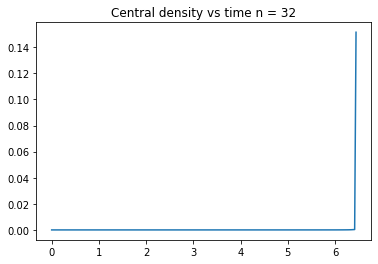

In [ ]:
# Resetting Gamma to 1.4 and changing K_0 to 0.98 to induce collapse:
InitialStar.EOS.reset_gamma0(1.4)
InitialStar.EOS.K_0 *= 0.98

# evolve the star
t_final = 20

Integrate = Integrator(m, n_m, InitialStar)
rho, R, u, P, energy = Integrate.init_data()

time32, cen_den32, u, mass = Integrate.integrate(t_final, n_plot, n_t, plots)

plt.plot(time32, cen_den32)
plt.title('Central density vs time n = 32')
plt.show()

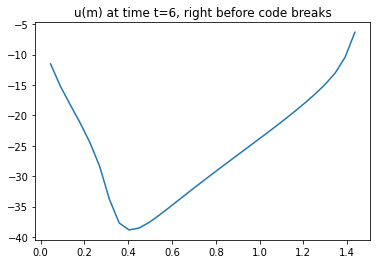

In [ ]:
plt.plot(mass[0], u[0])
plt.title('u(m) at time t=6, right before code breaks')
plt.show()

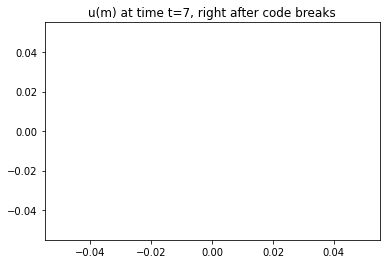

In [ ]:
plt.plot(mass[1], u[1])
plt.title('u(m) at time t=7, right after code breaks')
plt.show()

Here can see the velocity profile right before the code stops and right after. The first plot produces a profile, but the plot after does not return anything since integration stops.